In [1]:
import pandas as pd
import numpy as np
import re
from random import random
import emoji
from tqdm import notebook
def tqdm(x, **kargs):
    return notebook.tqdm(x, leave=False, **kargs)
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel
from sklearn.preprocessing import MultiLabelBinarizer

I0603 13:03:08.609767 140359886780224 file_utils.py:39] PyTorch version 1.5.0 available.


In [3]:
from simpletransformers.language_modeling import LanguageModelingModel

## Read input data

In [26]:
# df = pd.read_json('./source/train_gold.json', lines=True)
df = pd.read_json('./preprocessed/preprocess_train.json', lines=True)
df_new = df.copy()
df_new.head()

,idx,text,reply,categories
0,0,we can all agree that any song by Niall Horan .,oui oui,[yes]
1,1,Will you be install # ScottyFromMarketing ' ...,,[no]
2,2,Growing up my mum would call me a Nigga despit...,And he joins in ? ? ? Pour some hot grits o...,[smh]
3,3,Rest your head on my chest when the world feel...,😂😂😂😂😂,[wink]
4,4,Imagine Will Hernandez and Wills both doing a ...,,[yes]


In [27]:
# # Try shuffle data
# df_new = df.sample(frac=1).reset_index(drop=True)
# df_new.head()

In [28]:
categories_type = pd.read_json('./source/categories.json', lines=True)
categories_mapping = {v[0]: k for k, v in categories_type.to_dict('list').items()}

In [29]:
df_dev_ori = pd.read_json('./source/dev_unlabeled.json', lines=True)
df_dev = pd.read_json('./preprocessed/preprocess_dev.json', lines=True)
df_dev_result = df_dev.copy()[['text', 'reply']]
df_dev_result.head()

,text,reply
0,"Drop your cash app , use hashtag # BailoutHu...",$ tyratomaro # BailoutHumans
1,After interviewing with a few incredible peopl...,CONGRATS ! ! ! ! !
2,I know GTC festival not happening next month b...,
3,"Lordy , my daughter just said , "" I wonde...",
4,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...


In [30]:
df_test = pd.read_json('./source/test_unlabeled.json', lines=True)
df_test_result = df_test.copy()[['text', 'reply']]
df_test_result.head()

,text,reply
0,@Youngdeji_ I think if uzi and carti dropping ...,
1,For the third year in a row we’re discussing t...,
2,dababy album sounds like it was made for nigga...,That's why you bought it.
3,Majority of Indians don’t watch any sport othe...,@ZairaWasimmm got a great story because of the...
4,everybody is just now listening to @madisonbee...,


### Use multi-hot encoding and change column name

In [31]:
mlb = MultiLabelBinarizer()
multi_hot = mlb.fit_transform(df_new['categories'].values)
multi_hot_list = [list(_) for _ in multi_hot]

In [32]:
df_new['labels'] = multi_hot_list
df_new = df_new[['text', 'reply', 'labels']]
df_new.columns = ['text_a', 'text_b', 'labels']
df_dev_result.columns = ['text_a', 'text_b']
df_test_result.columns = ['text_a', 'text_b']

## Training language model first, can imporve accuracy!

In [33]:
# Output data to train_file for training LM
df_forLM = df_new.copy()
# df_forLM['text'] = ['<s> '] + df_new['text_a'] + [' </s></s> '] + df_new['text_b'] + [' <s>']
df_forLM['text'] = ['[CLS] '] + df_new['text_a'] + [' [SEP] '] + df_new['text_b'] + [' [SEP]']
# df_forLM_dev = df_dev_result.copy()
# df_forLM_dev['text'] = ['<s> '] + df_dev_result['text_a'] + [' </s></s> '] + df_dev_result['text_b'] + [' <s>']
# df_forLM_test = df_test_result.copy()
# df_forLM_test['text'] = ['<s> '] + df_test_result['text_a'] + [' [SEP] '] + df_test_result['text_b']
# pd.concat([df_forLM['text'], df_forLM_dev['text'], df_forLM_test['text']])[1]

In [34]:
df_forLM['text'].to_csv(r'LM/training.txt', header=None, index=None, sep=' ')
# pd.concat([df_forLM['text'], df_forLM_dev['text']]).to_csv(r'LM/training_dev.txt', header=None, index=None, sep=' ')
# pd.concat([df_forLM['text'], df_forLM_dev['text'], df_forLM_test['text']]).to_csv(r'LM/training_dev_test.txt', header=None, index=None, sep=' ')

In [36]:
train_lm_args = {
    "output_dir": "LM/outputs_bert_uncased_LM_training_preprocessed/",
    "cache_dir": "cache/",
    "best_model_dir": "LM/outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 113,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 4,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,
}
model = LanguageModelingModel("bert", "bert-base-uncased", args=train_lm_args)

I0603 13:57:27.989449 140359886780224 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at cache/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0603 13:57:28.919435 140359886780224 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at cache/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0603 13:57:28.920261 140359886780224 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings

In [37]:
model.train_model('LM/training.txt')

I0603 13:57:31.295145 140359886780224 language_modeling_utils.py:181]  Creating features from dataset file at cache/


I0603 13:57:34.919770 140359886780224 language_modeling_utils.py:229]  Saving features into cached file cache/bert_cached_lm_111_training.txt


I0603 13:57:34.946201 140359886780224 language_modeling_model.py:473]  Training started


Running loss: 2.317134

I0603 13:59:55.471956 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-689-epoch-1/config.json


I0603 13:59:55.708569 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-689-epoch-1/pytorch_model.bin


Running loss: 2.516955

I0603 14:02:17.024956 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-1378-epoch-2/config.json


I0603 14:02:17.248695 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-1378-epoch-2/pytorch_model.bin


Running loss: 2.273551

I0603 14:04:25.192951 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2000/config.json


Running loss: 2.271214

I0603 14:04:25.416197 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2000/pytorch_model.bin


Running loss: 2.730169

I0603 14:04:39.522027 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2067-epoch-3/config.json


I0603 14:04:39.744395 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2067-epoch-3/pytorch_model.bin


Running loss: 2.624485

I0603 14:07:01.557008 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2756-epoch-4/config.json


I0603 14:07:01.781935 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/checkpoint-2756-epoch-4/pytorch_model.bin
I0603 14:07:02.233439 140359886780224 configuration_utils.py:144] Configuration saved in LM/outputs_bert_uncased_LM_training_preprocessed/config.json


I0603 14:07:02.459305 140359886780224 modeling_utils.py:483] Model weights saved in LM/outputs_bert_uncased_LM_training_preprocessed/pytorch_model.bin
I0603 14:07:02.472314 140359886780224 language_modeling_model.py:402]  Training of bert model complete. Saved to LM/outputs_bert_uncased_LM_training_preprocessed/.


## Training model

In [66]:
train_args = {
    "output_dir": "model_results_gpu/outputs_roberta_training_preprocessed/",
    "cache_dir": "cache/",
    "best_model_dir": "model_results_gpu/outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 113,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 4,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": False,
    "save_steps": 2000,
    "no_cache": True,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": False,
    "reprocess_input_data": True,

    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": False,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": None,
    "encoding": None,
    "config": {}
}

In [67]:
# model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=43, args=train_args)
# Read from pretrained language model
model = MultiLabelClassificationModel('roberta', 'LM/outputs_roberta_LM_training_preprocessed', num_labels=43, args=train_args)

I0603 15:33:38.872920 140359886780224 configuration_utils.py:283] loading configuration file LM/outputs_roberta_LM_training_preprocessed/config.json
I0603 15:33:38.873671 140359886780224 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
  

In [68]:
model.train_model(df_new)

I0603 15:33:44.631558 140359886780224 classification_model.py:801]  Converting to features started. Cache is not used.


I0603 15:33:51.105255 140359886780224 classification_model.py:367]    Starting fine-tuning.


Running loss: 0.092893

I0603 15:38:57.064907 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-1000-epoch-1/config.json


I0603 15:38:57.352392 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-1000-epoch-1/pytorch_model.bin


Running loss: 0.144542

I0603 15:44:05.242049 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-2000/config.json
I0603 15:44:05.536704 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-2000/pytorch_model.bin
I0603 15:44:06.263444 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-2000-epoch-2/config.json


I0603 15:44:06.557447 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-2000-epoch-2/pytorch_model.bin


Running loss: 0.093893

I0603 15:49:14.642549 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-3000-epoch-3/config.json


I0603 15:49:14.935518 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-3000-epoch-3/pytorch_model.bin


Running loss: 0.129605

I0603 15:54:23.209842 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-4000/config.json
I0603 15:54:23.495933 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-4000/pytorch_model.bin
I0603 15:54:24.117335 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-4000-epoch-4/config.json


I0603 15:54:24.403540 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/checkpoint-4000-epoch-4/pytorch_model.bin
I0603 15:54:25.023161 140359886780224 configuration_utils.py:144] Configuration saved in model_results_gpu/outputs_roberta_training_preprocessed/config.json


I0603 15:54:25.316444 140359886780224 modeling_utils.py:483] Model weights saved in model_results_gpu/outputs_roberta_training_preprocessed/pytorch_model.bin
I0603 15:54:25.451917 140359886780224 classification_model.py:279]  Training of roberta model complete. Saved to model_results_gpu/outputs_roberta_training_preprocessed/.


### Load model (unused can comment)

In [35]:
# model = MultiLabelClassificationModel('roberta', 'model_results_gpu/outputs_roberta_#64/checkpoint-6000-epoch-3')

I0531 07:08:04.448168 140289921820480 configuration_utils.py:283] loading configuration file model_results_gpu/outputs_roberta_#64/checkpoint-6000-epoch-3/config.json
I0531 07:08:04.452016 140289921820480 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    

### Evaluating model for LRAP and mAP

In [69]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_new)
print(result)


{'LRAP': 0.5373189964402629, 'eval_loss': 0.10006559572741389}


In [70]:
avg_map = 0
total_predict = []

predict_ok_yes = 0
unpredict_class = defaultdict(lambda: 0)
record_unpredict_class = defaultdict(lambda: defaultdict(lambda: 0))

for eid, each_outputs in enumerate(model_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(model_outputs[eid])), key=lambda k: model_outputs[eid][k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            if key in df['categories'][eid]:
                correct += 1
            predict_class.append(key)
    # Check what not predicted correct
    check = predict_class.copy()
    unmatch = df['categories'][eid].copy()
    for each_class in df['categories'][eid]:
        if each_class not in predict_class:
            unpredict_class[each_class] += 1
        else:
            unmatch.remove(each_class)
            check.remove(each_class)
    for each_class in unmatch:
        for each_check in check:
            record_unpredict_class[each_class][each_check] += 1
    if 'ok' in predict_class and 'yes' in predict_class:
        predict_ok_yes += 1
    
    avg_map += (correct / len(df['categories'][eid]))
    total_predict.append(predict_class)

avg_map /= len(df['categories'])
print("avg map = {}".format(avg_map))

avg map = 0.6769109374999988


In [99]:
predict_ok_yes

2594

In [107]:
both_ok_agree = 0
only_ok = 0
only_agree = 0
for i in range(len(df)):
    if 'ok' in df['categories'][i] and 'agree' in df['categories'][i]:
        both_ok_agree += 1
    elif 'ok' in df['categories'][i] and 'agree' not in df['categories'][i]:
        only_ok += 1
    elif 'ok' not in df['categories'][i] and 'agree' in df['categories'][i]:
        only_agree += 1
print(both_ok_agree)
print(only_ok)
print(only_agree)

71
807
2916


In [106]:
# sorted(categories_dict.items(), key=lambda d: d[1], reverse=True)
record_unpredict_class['ok']

defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
            {'eww': 66,
             'idk': 96,
             'oh_snap': 90,
             'omg': 203,
             'scared': 85,
             'shocked': 264,
             'agree': 370,
             'applause': 388,
             'no': 177,
             'seriously': 276,
             'slow_clap': 185,
             'yes': 357,
             'awww': 141,
             'dance': 159,
             'happy_dance': 135,
             'please': 65,
             'wink': 40,
             'facepalm': 197,
             'sigh': 176,
             'smh': 200,
             'popcorn': 55,
             'thank_you': 86,
             'hearts': 48,
             'hug': 82,
             'you_got_this': 59,
             'oops': 62,
             'high_five': 21,
             'good_luck': 73,
             'win': 16,
             'shrug': 34,
             'thumbs_up': 28,
             'eye_roll': 63,
             'do_not_want': 8,
             'want': 6,
   

In [102]:
sorted(unpredict_class.items(), key=lambda d: d[1], reverse=True) 

[('ok', 762),
 ('shrug', 634),
 ('eww', 610),
 ('oops', 579),
 ('omg', 561),
 ('scared', 545),
 ('eye_roll', 542),
 ('oh_snap', 493),
 ('no', 490),
 ('idk', 479),
 ('wink', 466),
 ('high_five', 460),
 ('shocked', 441),
 ('deal_with_it', 429),
 ('yawn', 426),
 ('sigh', 411),
 ('thumbs_up', 390),
 ('awww', 367),
 ('win', 356),
 ('agree', 348),
 ('popcorn', 340),
 ('yes', 304),
 ('smh', 302),
 ('thank_you', 300),
 ('fist_bump', 292),
 ('sorry', 287),
 ('applause', 282),
 ('seriously', 265),
 ('facepalm', 264),
 ('do_not_want', 241),
 ('want', 231),
 ('please', 225),
 ('thumbs_down', 220),
 ('dance', 217),
 ('slow_clap', 214),
 ('happy_dance', 208),
 ('yolo', 197),
 ('good_luck', 179),
 ('mic_drop', 170),
 ('kiss', 166),
 ('you_got_this', 151),
 ('hearts', 124),
 ('hug', 100)]

## Predict results [pair sentance](https://simpletransformers.ai/docs/classification-data-formats/)

In [71]:
# text + [SEP] + reply
to_predict = []
for i in range(len(df_dev_result)):
    # for roberta format
    text_reply = '<s> ' + df_dev_result['text_a'][i] + ' </s></s> ' + df_dev_result['text_b'][i] + ' <s>'
#     for bert format
#     text_reply = '[CLS] ' + df_dev_result['text_a'][i] + ' [SEP] ' + df_dev_result['text_b'][i] + ' [SEP]'
    to_predict.append(text_reply)

In [72]:
predictions, raw_outputs = model.predict(to_predict)

I0603 16:07:48.571024 140359886780224 classification_model.py:801]  Converting to features started. Cache is not used.


In [73]:
total_predict = []
for eid, row in enumerate(raw_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [74]:
df_dev_ori['categories'] = total_predict

In [75]:
df_dev_ori.head()

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[applause, dance, good_luck, happy_dance, plea..."
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[agree, applause, high_five, slow_clap, thumbs..."
2,32002,I know GTC festival not happening next month b...,,"[facepalm, no, scared, seriously, sigh, smh]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[applause, eww, facepalm, oh_snap, omg, shocked]"
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[eye_roll, facepalm, seriously, shrug, sigh, smh]"


In [76]:
df_dev_ori.to_json('./results/dev.json', orient='records', lines=True)

## Power n weighted sum to blend models (Try average first)

In [173]:
model_roberta_base = MultiLabelClassificationModel('roberta', 'model_results_gpu/outputs_roberta_training_#87/')
# model_xlmroberta_base = MultiLabelClassificationModel('xlmroberta', 'model_results_gpu/outputs_xlmroberta_#66/')
model_bert_base_uncased = MultiLabelClassificationModel('bert', 'model_results_gpu/outputs_bert_uncased_training_#92/')
model_bert_base_cased = MultiLabelClassificationModel('bert', 'model_results_gpu/outputs_bert_cased_training_#93/')

I0601 16:48:35.482314 139779627980608 configuration_utils.py:283] loading configuration file model_results_gpu/outputs_roberta_training_#87/config.json
I0601 16:48:35.483019 139779627980608 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23

I0601 16:48:43.279752 139779627980608 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",

In [174]:
predictions_roberta_base, raw_outputs_roberta_base = model_roberta_base.predict(to_predict)
# predictions_xlmroberta_base, raw_outputs_xlmroberta_base = model_xlmroberta_base.predict(to_predict)
predictions_bert_base_uncased, raw_outputs_bert_base_uncased = model_bert_base_uncased.predict(to_predict)
predictions_bert_base_cased, raw_outputs_bert_base_cased = model_bert_base_cased.predict(to_predict)

I0601 16:50:13.922566 139779627980608 classification_model.py:801]  Converting to features started. Cache is not used.


I0601 16:50:27.369440 139779627980608 classification_model.py:801]  Converting to features started. Cache is not used.


I0601 16:50:41.028582 139779627980608 classification_model.py:801]  Converting to features started. Cache is not used.


In [175]:
print(raw_outputs_roberta_base[0])
# print(raw_outputs_xlmroberta_base[0])
print(raw_outputs_bert_base_uncased[0])
print(raw_outputs_bert_base_cased[0])

[0.02645903 0.10327499 0.03311556 0.05657279 0.00648181 0.00293745
 0.00533747 0.00601103 0.00631634 0.01446454 0.17714569 0.04154743
 0.02221017 0.02777012 0.02029944 0.00463329 0.00927887 0.0037198
 0.00842672 0.00784296 0.01934045 0.01441806 0.00511787 0.30099168
 0.00598345 0.00995661 0.00670238 0.0104104  0.00400015 0.0101754
 0.03269726 0.00562772 0.00344808 0.04705882 0.00422613 0.01852409
 0.01474785 0.01721057 0.01229597 0.00395585 0.03457728 0.00400766
 0.04768348]
[0.02078844 0.10037786 0.03057312 0.10406715 0.00828542 0.00479606
 0.00503582 0.00828322 0.00806296 0.01815269 0.12900525 0.07502341
 0.02855058 0.02924531 0.01486535 0.00473417 0.0154389  0.00295408
 0.00696931 0.0041835  0.01842031 0.01044888 0.00485222 0.24313185
 0.01325911 0.00796377 0.00695796 0.0052148  0.00579062 0.00924185
 0.02309374 0.00738855 0.00792435 0.05473048 0.00321092 0.02384039
 0.0144172  0.02597312 0.02158143 0.00610717 0.04183538 0.00582641
 0.0492948 ]
[0.03709638 0.13854958 0.02369575 0.06

In [196]:
P = 3.5
total_predict = []
for eid, row_roberta_base in enumerate(raw_outputs_roberta_base):
    row = (row_roberta_base ** P) * 3.0 + \
            (raw_outputs_bert_base_uncased[eid] ** P) * 0.8 + (raw_outputs_bert_base_cased[eid] ** P) * 0.8 
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [53]:
df_dev_ori['categories'] = total_predict

In [54]:
df_dev_ori.head()

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[applause, dance, good_luck, happy_dance, plea..."
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[agree, applause, slow_clap, thumbs_up, win, yes]"
2,32002,I know GTC festival not happening next month b...,,"[idk, no, scared, seriously, shrug, sigh]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[applause, facepalm, oh_snap, omg, scared, sho..."
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[applause, dance, omg, popcorn, shocked, yes]"


In [56]:
df_dev_ori.to_json('./results/dev.json', orient='records', lines=True)

# Below are Stastistics

In [81]:
from transformers import BertModel, BertTokenizer, RobertaTokenizer, BertForSequenceClassification
from transformers.modeling_bert import BertPreTrainedModel

### Count min, max, and average text length to select proper max_seq_length

In [103]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
text_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_bar = []
for each_text in df['text']:
    each_cnt = len(tokenizer.tokenize(each_text))
    text_cnt += each_cnt
    text_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_level = Counter(sorted(text_bar))
print("Max text length is: {}".format(max_cnt))
print("Min text length is: {}".format(min_cnt))
print("Average text length is: {}".format(text_cnt / len(df['text'])))

I0528 11:37:52.815811 140258912331584 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/ino/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I0528 11:37:52.817564 140258912331584 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/ino/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


Max text length is: 587
Min text length is: 1
Average text length is: 30.57615625


### Count max, min, and average reply length to select proper max_seq_length

In [107]:
reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
reply_bar = []
for each_reply in df['reply']:
    each_cnt = len(tokenizer.tokenize(each_reply))
    reply_cnt += each_cnt
    reply_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
reply_level = Counter(sorted(reply_bar))
print("Max reply length is: {}".format(max_cnt))
print("Min reply length is: {}".format(min_cnt))
print("Average reply length is: {}".format(reply_cnt / len(df['reply'])))

Max reply length is: 292
Min reply length is: 0
Average reply length is: 5.54871875


### Count max, min, and average text + reply length to select proper max_seq_length

In [127]:
text_reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_reply_bar = []
for eid, each_reply in enumerate(df['reply']):
    each_text_cnt = len(tokenizer.tokenize(df['text'][eid]))
    each_reply_cnt = len(tokenizer.tokenize(each_reply))
    each_cnt = each_text_cnt + each_reply_cnt
    text_reply_bar.append(each_cnt // 10)
    text_reply_cnt += each_cnt
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_reply_level = Counter(sorted(text_reply_bar))
print("Max text + reply length is: {}".format(max_cnt))
print("Min text + reply length is: {}".format(min_cnt))
print("Average text + reply length is: {}".format(text_reply_cnt / len(df['reply'])))

Max text + reply length is: 587
Min text + reply length is: 1
Average text + reply length is: 36.124875


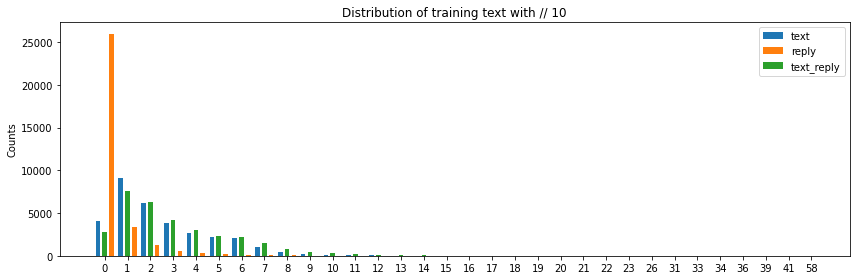

In [142]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

text_indices = np.arange(len(text_level))
reply_indices = np.arange(len(reply_level))
text_reply_indices = np.arange(len(text_reply_level))
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
width = 0.2
results_text = plt.bar(text_indices - 0.3, list(text_level.values()), width, label='text')
results_reply = plt.bar(reply_indices + 0.3, list(reply_level.values()), width, label='reply')
results_text_reply = plt.bar(text_reply_indices, list(text_reply_level.values()), width, label='text_reply')

plt.xticks(range(len(text_reply_level)), list(text_reply_level.keys()))
ax.set_ylabel('Counts')
ax.set_title('Distribution of training text with // 10')
# ax.set_xticks(x)
# ax.set_xticklabels(text_reply_indices)
ax.legend()

# autolabel(results_text)
# autolabel(results_reply)
# autolabel(results_text_reply)

fig.tight_layout()
plt.show()

In [11]:
# There isn't null value in training data
print(df.isnull().sum())
print(df_dev.isnull().sum())

idx           0
text          0
reply         0
categories    0
mp4           0
dtype: int64
idx      0
text     0
reply    0
dtype: int64


In [12]:
df.text.unique()

array(['we can all agree that any song by Niall Horan.',
       "Will you be installing #ScottyFromMarketing's new tracking app. \n\nPlease answer in the form of a gif.",
       'Growing up my mum would call me a Nigga despite her not being black. I would tell her to stop but she would only call me more racist slurs and hit me. I recently started dating a white boy and she’s being making more slurs and he joins in. What should i do? -anon',
       ..., 'Your @3rd is your future ex',
       'If tell you a duck can pull a truck, hook that mf up',
       'The only receipts in life are our memories weather you instill them in family or yourself make them count because they are non returnable. Love yall stay grinding.'],
      dtype=object)

In [93]:
torch.cuda.empty_cache()

## To-Do or Want-To-Do

- https://arxiv.org/pdf/1905.05583.pdf
    - [X] Try to count training and testing average length to modify max_seq_length
    - [ ] Head 128 + tail 382 when larger than 512 tokens get best results.
- [ ] [Exploratory Data Analysis](https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/?fbclid=IwAR07KpVViBMrZx5aboOMe2CPr4_QizPNoyW_Fdl6L1ZNN0_lhhGyl1KZxRg)
- [ ] [Blend models  10th](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/101630)
- [X] [Blend models 2nd](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/100661)
- [ ] [Data cleaning](https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda)
- [ ] [Stopword removal](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf)
- [ ] [Preprocess EDA](https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda)
- [X] Shuffle data (no good)
- [ ] [Data cleaning](https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2)
- [ ] [EDA preprocessing DO FIRST!!](https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw)
    - [ ] Check Roberta tokenizer proportion and data include proportion
    - [ ] Draw text cloud

In [ ]:
# https://www.reddit.com/r/LanguageTechnology/comments/gnkeyl/covidtwitterbert_an_nlp_model_to_analyse_content/

In [63]:
# Visualization of training classes
total_classes = 0
categories_dict = defaultdict(lambda: 0)
for i in range(len(df)):
    for each_category in df['categories'][i]:
        categories_dict[each_category] += 1
        total_classes += 1
for key in categories_dict:
    categories_dict[key] = categories_dict[key]

Text(0.5, 1.0, 'Emotions Unnormalized')

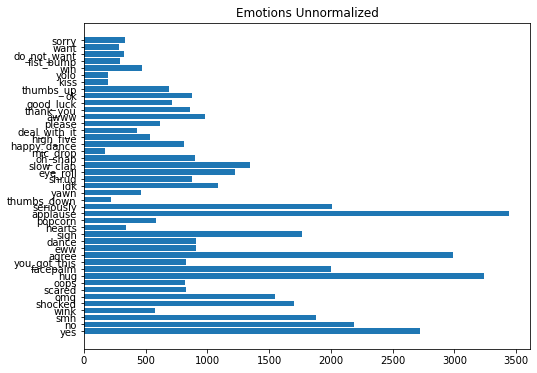

In [64]:
plt.figure(figsize=(8, 6))
plt.barh(list(categories_dict.keys()), categories_dict.values())
plt.title('Emotions Unnormalized')

In [71]:
# https://stackoverflow.com/questions/57021620/how-to-calculate-unbalanced-weights-for-bcewithlogitsloss-in-pytorch
categories_dict_pos = categories_dict.copy()
for key in categories_dict_pos:
    categories_dict_pos[key] = (total_classes - categories_dict_pos[key]) / categories_dict_pos[key]
categories_dict_pos

defaultdict(<function __main__.<lambda>()>,
            {'yes': 15.978668628172121,
             'no': 20.128146453089244,
             'smh': 23.54279638490165,
             'wink': 79.42682926829268,
             'shocked': 26.09213615023474,
             'omg': 28.764667956157318,
             'scared': 54.6875753920386,
             'oops': 55.57475490196079,
             'hug': 13.252855819697437,
             'facepalm': 22.070964517741128,
             'you_got_this': 54.822249093107615,
             'agree': 14.455306327418814,
             'eww': 49.73076923076923,
             'dance': 49.61951754385965,
             'sigh': 25.111425339366516,
             'hearts': 135.17994100294985,
             'popcorn': 78.1852487135506,
             'applause': 12.412260313771064,
             'seriously': 21.944831013916502,
             'thumbs_down': 208.8409090909091,
             'yawn': 99.1409978308026,
             'idk': 41.54838709677419,
             'shrug': 51.88087056128

In [73]:
class_weight = sorted(categories_dict_pos.items(), key=lambda pair: categories_mapping[pair[0]])
class_weight = [_[1] for _ in class_weight]
class_weight

[14.455306327418814,
 12.412260313771064,
 46.2517911975435,
 49.61951754385965,
 106.6107226107226,
 140.17737003058105,
 49.73076923076923,
 36.80917280917281,
 22.070964517741128,
 157.09931506849315,
 64.02112676056338,
 55.99382716049383,
 135.17994100294985,
 85.28971962616822,
 13.252855819697437,
 41.54838709677419,
 238.19689119170985,
 270.55882352941177,
 20.128146453089244,
 50.067477876106196,
 51.57972665148064,
 28.764667956157318,
 55.57475490196079,
 73.94318181818181,
 78.1852487135506,
 54.6875753920386,
 21.944831013916502,
 26.09213615023474,
 51.88087056128293,
 25.111425339366516,
 33.374534623976174,
 23.54279638490165,
 136.39583333333334,
 52.68023255813954,
 208.8409090909091,
 65.71242774566474,
 162.12720848056537,
 96.39451476793249,
 79.42682926829268,
 99.1409978308026,
 15.978668628172121,
 233.34010152284264,
 54.822249093107615]

In [50]:
categories_mapping

{'agree': 0,
 'applause': 1,
 'awww': 2,
 'dance': 3,
 'deal_with_it': 4,
 'do_not_want': 5,
 'eww': 6,
 'eye_roll': 7,
 'facepalm': 8,
 'fist_bump': 9,
 'good_luck': 10,
 'happy_dance': 11,
 'hearts': 12,
 'high_five': 13,
 'hug': 14,
 'idk': 15,
 'kiss': 16,
 'mic_drop': 17,
 'no': 18,
 'oh_snap': 19,
 'ok': 20,
 'omg': 21,
 'oops': 22,
 'please': 23,
 'popcorn': 24,
 'scared': 25,
 'seriously': 26,
 'shocked': 27,
 'shrug': 28,
 'sigh': 29,
 'slow_clap': 30,
 'smh': 31,
 'sorry': 32,
 'thank_you': 33,
 'thumbs_down': 34,
 'thumbs_up': 35,
 'want': 36,
 'win': 37,
 'wink': 38,
 'yawn': 39,
 'yes': 40,
 'yolo': 41,
 'you_got_this': 42}